In [17]:
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
import pandas as pd
import cv2
from PIL import Image

In [140]:
#intializing the variables
n_epochs = 10000
batch_size = 4
lr = 0.00009
n_cpu = 1
latent_dim = 100
n_classes = 26
img_size = 36
channels = 1
b1 = 0.5
b2 = 0.999
sample_interval = 100

In [3]:
img_shape = (channels, img_size, img_size)
cuda = True if torch.cuda.is_available() else False
# cuda

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes,  n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block( latent_dim +  n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding( n_classes,  n_classes)

        self.model = nn.Sequential(
            nn.Linear( n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        # print("IMage",img.shape,"Labels",labels.shape)
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        # print("d_in",d_in.shape)
        validity = self.model(d_in)
        return validity

In [141]:
adversarial_loss = torch.nn.MSELoss() # tried with BCE too But got MSE to work better with my model 

In [142]:
#intializing the generator and discriminator
generator = Generator() 
generator.train()
discriminator = Discriminator()

In [143]:
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [151]:
class Alphabet(Dataset):
    def __init__(self, path, img_size, transform=None):
        self.transform = transform
        df = pd.read_csv(path)
        self.images = np.array([cv2.imread(i).astype('uint8') for i in df.iloc[:,0].values])
        self.labels = df.label.values
        # print('Image size:', self.images.shape)
        # print('--- Label ---')
        # print(df.label.value_counts())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]-65
        img = self.images[idx]
        img = Image.fromarray(self.images[idx])
            
        if self.transform:
            img = self.transform(img)
        
        return img, label
        
transform = transforms.Compose([
        transforms.Resize( img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,)),
        transforms.Grayscale(1)
])

#Already created a csv file with images and labels as data.csv
dataset = Alphabet('data.csv', img_size, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [11]:
for i, (imgs, labels) in enumerate(dataloader):
    print(i, (imgs.shape, labels.shape))
    break

0 (torch.Size([4, 1, 36, 36]), torch.Size([4]))


In [144]:
#Tried a few learning rates 
optimizer_G = torch.optim.Adam(generator.parameters(), lr= lr, betas=( b1,  b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr= lr, betas=( b1,  b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [152]:
#to save the images 
def sample_image(n_row, batches_done):
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2,  latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "images_4/%d.png" % batches_done, nrow=n_row, normalize=True)

In [ ]:
#training loop
for epoch in range( n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))
        
        #  Train Generator

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size,  latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0,  n_classes, batch_size)))

        # print(z.shape,gen_labels.shape)
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()
        
        #  Train Discriminator

        optimizer_D.zero_grad()

        # print("Gen_imgs",gen_imgs.shape)
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)
        
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        

        batches_done = epoch * len(dataloader) + i
        if batches_done %  sample_interval == 0:
            sample_image(n_row=26, batches_done=batches_done)
    print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch,  n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )
# Saving the Generator 4 means the number of iterations it took to get the best in time
torch.save(generator.state_dict(), "CGAN_4.pth")

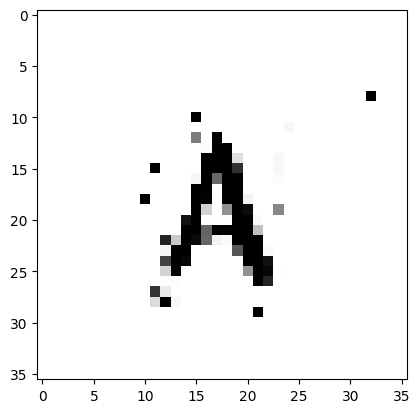

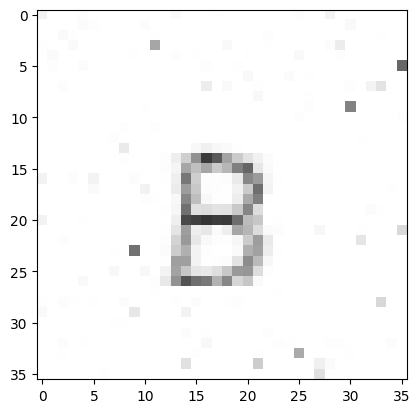

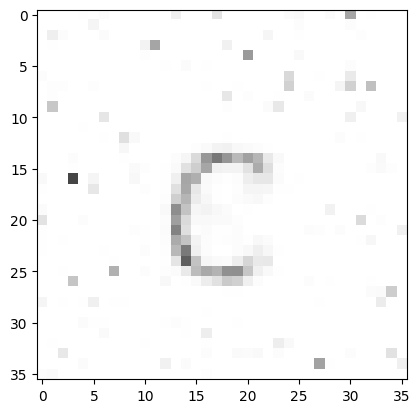

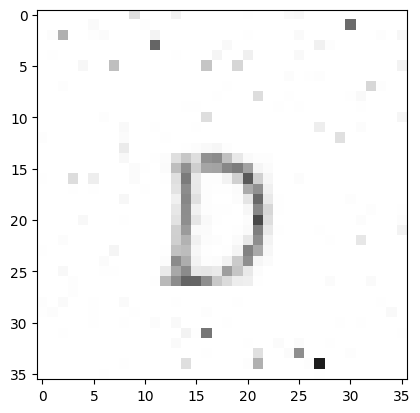

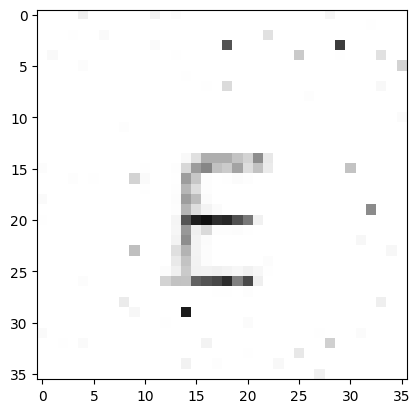

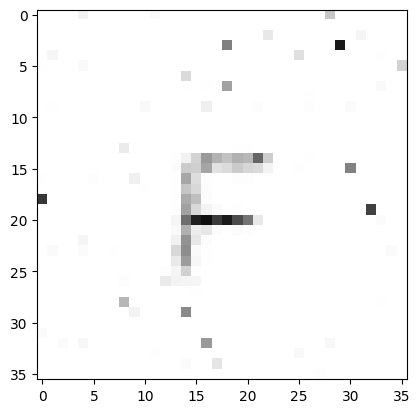

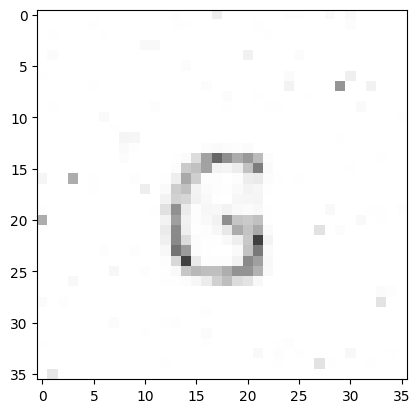

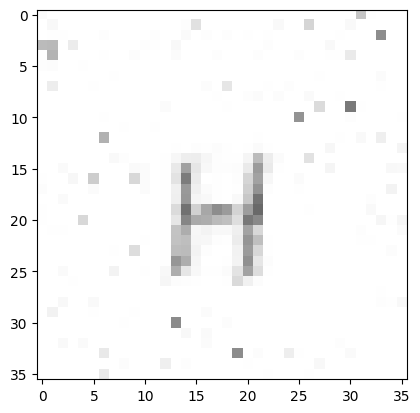

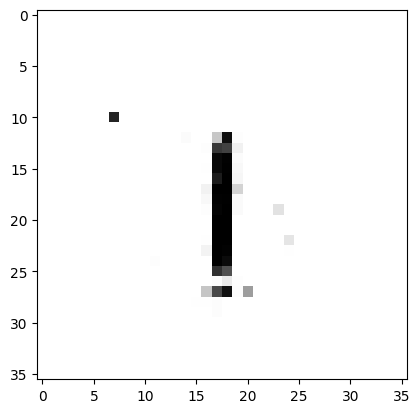

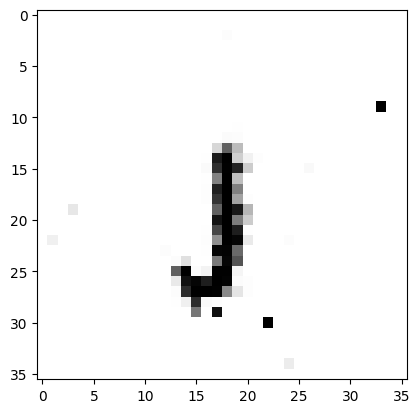

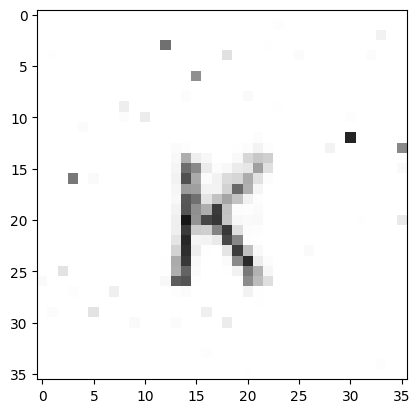

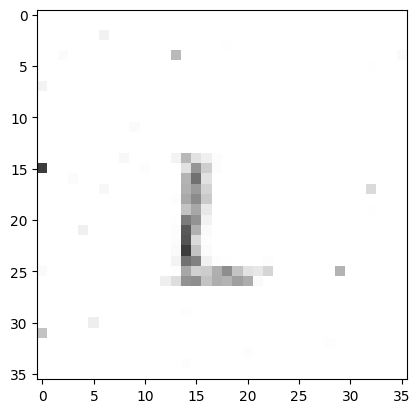

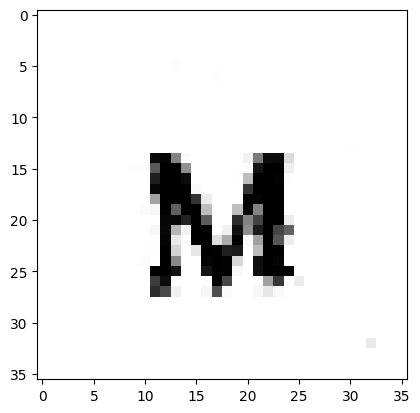

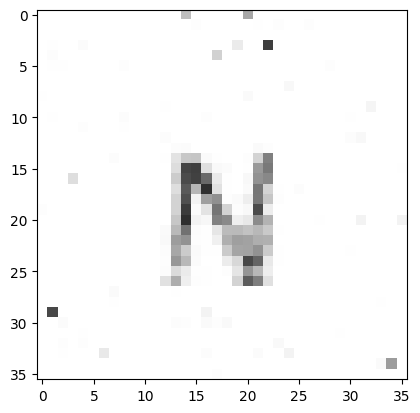

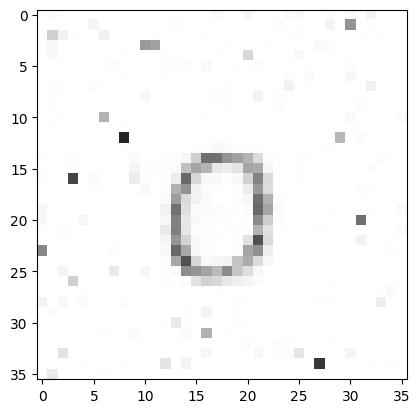

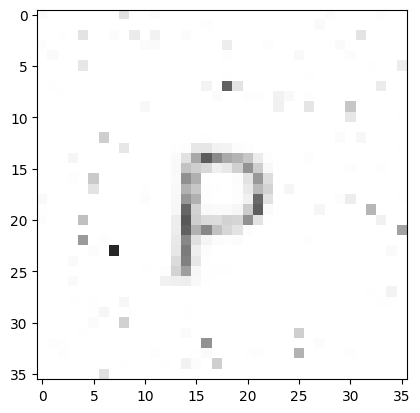

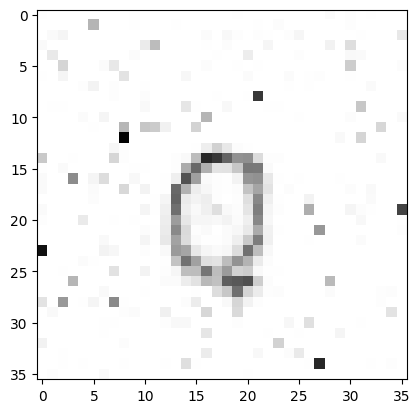

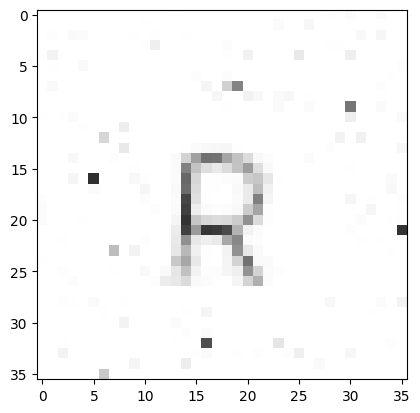

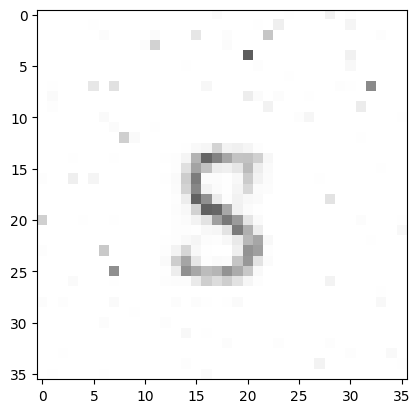

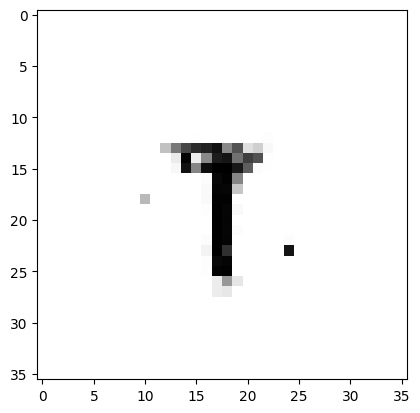

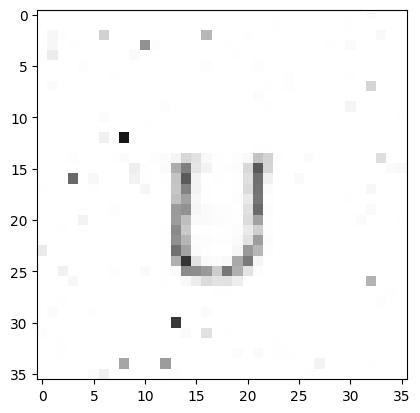

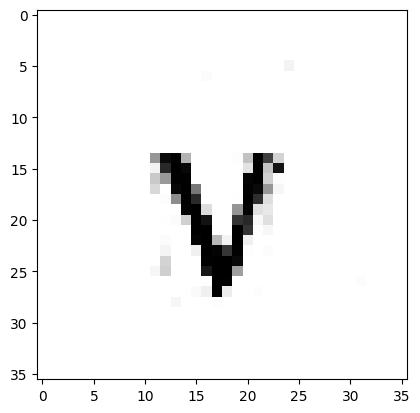

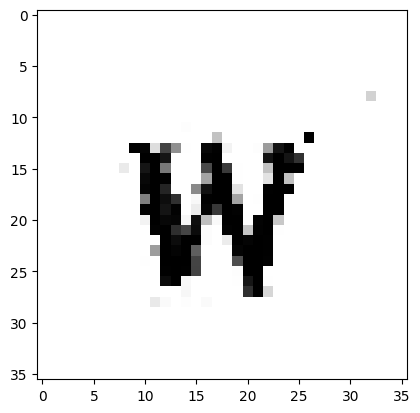

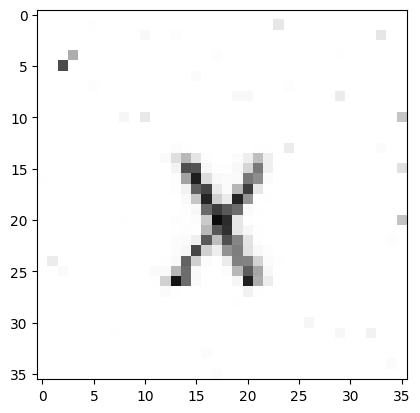

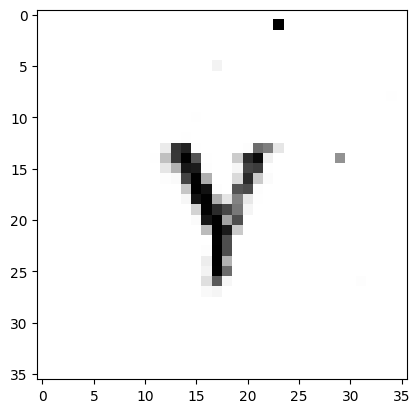

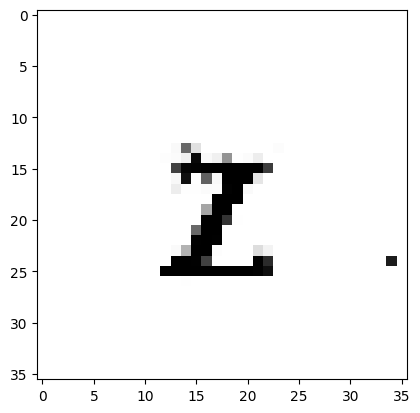

In [202]:
#The Raw Ouptuts from the Generator
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
gen = Generator()
gen.load_state_dict(torch.load("CGAN_4.pth"))
gen.eval()
gen = gen.to('cuda')
import matplotlib.pyplot as plt

with torch.no_grad():
    n_row =  26
    
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2,  latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = gen(z, labels)
    for i in range(26):
        img = ((gen_imgs[i]+1.0)/2.0*255.0)
        # print(img.shape)
        img = img.view(36,36).detach().cpu().numpy()
        # print(img.shape)
        # plt.imshow(img)
        plt.imshow(img, cmap='gray', vmin = 0, vmax = 255)
        plt.show()

In [200]:
#intializing the function

# tried a few image processing techniques to get on the best one
# also tried contouring it but dropped it due to lack of time 
'''I could have build a more cleaner images with image processing'''
def generateImage(char,n):
    with torch.no_grad():
        n_row =  26
        letter = char-1
        
        z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2,  latent_dim))))
        labels = np.array([num for _ in range(n_row) for num in range(n_row)])
        labels = Variable(LongTensor(labels))
        gen_imgs = gen(z, labels)
    
        gen_imgs = ((gen_imgs)*255.0)
        img = cv2.resize(gen_imgs[26+letter].view(36,36).detach().cpu().numpy(),(128,128))
        
        # Some Image Processing to reduce the noise in the output 
        # img = cv2.blur(img,(1,1))
        for i in range(2):
            img = cv2.bilateralFilter(img,10,35,25)
        threshold ,thresh = cv2.threshold(img, 200, 255,cv2.THRESH_BINARY)

        for i in range(2):
            img = cv2.pyrDown(thresh)
        for _ in range(30):
            img = cv2.bilateralFilter(img, 3, 3, 7)
        for _ in range(2):
            img = cv2.pyrUp(img)
        threshold ,thresh = cv2.threshold(img, 170, 255,cv2.THRESH_BINARY)

        #plotting the Image
        # plt.imshow(thresh)
        plt.imshow(thresh, cmap='gray', vmin = 0, vmax = 255)
        plt.show()
        return img

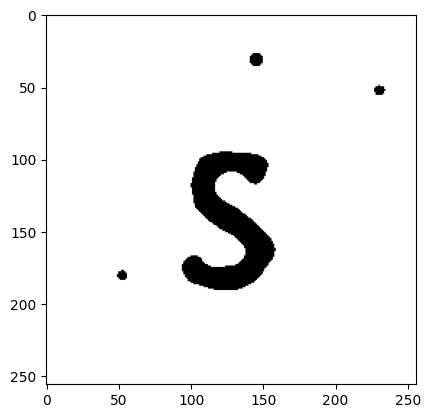

In [201]:
if __name__=="__main__":
    if False:
        trainModel()
    if True:
        character = 19    # this could be a number between 1-26 corresponding to A-Z
        noise = np.random.normal(10)
        Y = generateImage(character, noise)
        outfile = f'test/img{chr(i-1+65)}.jpg'
        Y = cv2.resize(Y,(128,128))
        cv2.imwrite(outfile, Y)